<a href="https://colab.research.google.com/github/hepi1911/ML/blob/main/Project_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score

Dataset: https://www.kaggle.com/datasets/mansoordaku/ckdisease/data

In [2]:
import kagglehub as kgb

# Download latest version
path = kgb.dataset_download("mansoordaku/ckdisease")

print("Path to dataset files:", path)

100%|██████████| 9.51k/9.51k [00:00<00:00, 10.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mansoordaku/ckdisease/versions/1


# Data Exploration

In [3]:
df = pd.read_csv(f'{path}/kidney_disease.csv')
df

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,47,6700,4.9,no,no,no,good,no,no,notckd
396,396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,54,7800,6.2,no,no,no,good,no,no,notckd
397,397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,49,6600,5.4,no,no,no,good,no,no,notckd
398,398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,51,7200,5.9,no,no,no,good,no,no,notckd


In [4]:
column_names_mapping = {
    'pcv': 'Packed Cell Volume',
    'sc': 'Serum Creatinine',
    'hemo': 'Hemoglobin',
    'rc': 'Red Blood Cells Count',
    'sg': 'Specific Gravity',
    'al': 'Albumin',
    'dm': 'Diabetes Mellitus',
    'htn': 'Hypertension',
    'bu': 'Blood Urea',
    'bgr': 'Blood Glucose Random',
    'sod': 'Sodium',
    'age': 'Age',
    'bp': 'Blood Pressure',
    'pe': 'Pedal Edema',
    'pot': 'Potassium',
    'wc': 'White Blood Cells Count',
    'pc': 'Pus Cell',
    'su': 'Sugar',
    'rbc': 'Red Blood Cells',
    'appet': 'Appetite',
    'ane': 'Anemia',
    'pcc': 'Pus Cell Clumps',
    'cad': 'Coronary Artery Disease',
    'ba': 'Bacteria'
}

df = df.rename(columns=column_names_mapping)

EDA a prendre avec enormement de precaution ( beaucoup de valeurs et d'info ) il faudra le reduire

## Missing values

                         Valeurs manquantes  Pourcentage (%)
Red Blood Cells                         152            38.00
Red Blood Cells Count                   130            32.50
White Blood Cells Count                 105            26.25
Potassium                                88            22.00
Sodium                                   87            21.75
Packed Cell Volume                       70            17.50
Pus Cell                                 65            16.25
Hemoglobin                               52            13.00
Sugar                                    49            12.25
Specific Gravity                         47            11.75
Albumin                                  46            11.50
Blood Glucose Random                     44            11.00
Blood Urea                               19             4.75
Serum Creatinine                         17             4.25
Blood Pressure                           12             3.00
Age                     

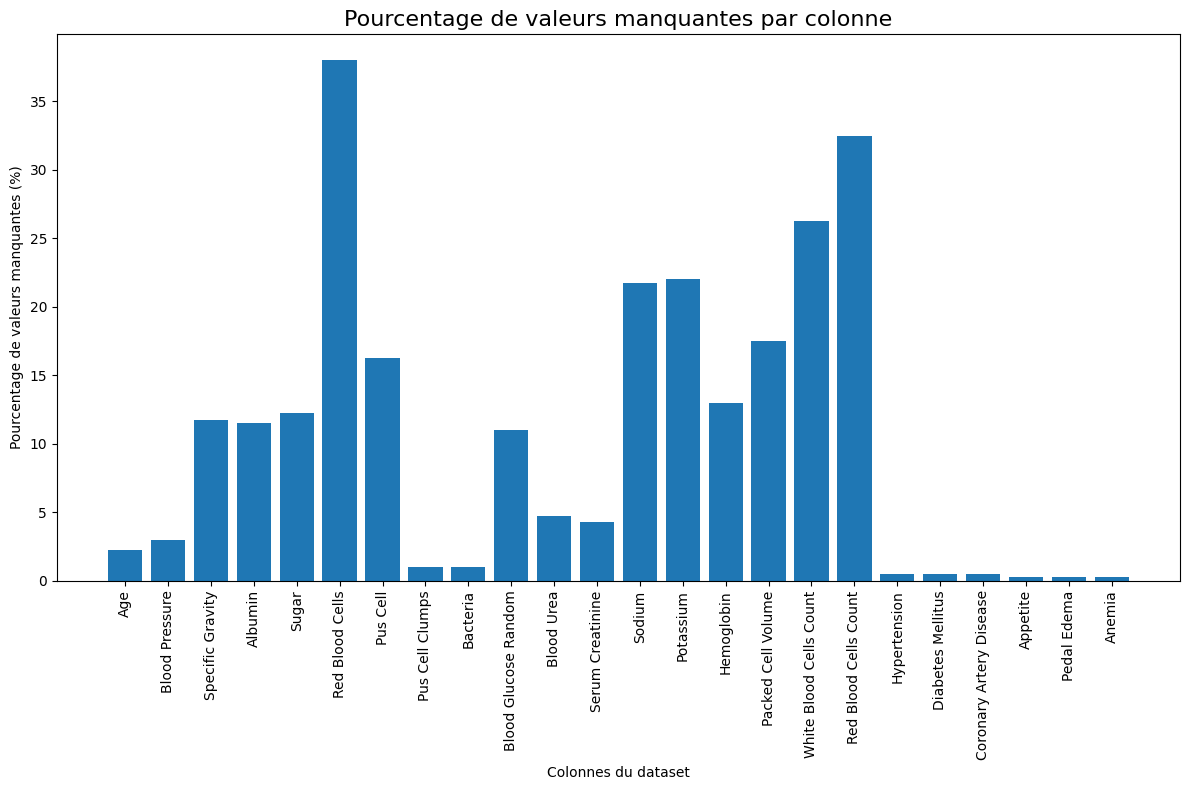

In [5]:
# 1. Analyse des valeurs manquantes
df_clean = df.replace(['\t', '?', '', 'nan', 'NaN', 'na'], np.nan)

# Compter les valeurs manquantes
missing_values = df_clean.isnull().sum()
missing_percent = (df_clean.isnull().sum() / len(df_clean)) * 100
missing_df = pd.DataFrame({
    'Valeurs manquantes': missing_values,
    'Pourcentage (%)': missing_percent.round(2)
})
print(missing_df[missing_df['Valeurs manquantes'] > 0].sort_values('Pourcentage (%)', ascending=False))

# Visualisation des valeurs manquantes
plt.figure(figsize=(12, 8))
plt.title('Pourcentage de valeurs manquantes par colonne', fontsize=16)
plt.bar(missing_df[missing_df['Valeurs manquantes'] > 0].index,
        missing_df[missing_df['Valeurs manquantes'] > 0]['Pourcentage (%)'])
plt.xticks(rotation=90)
plt.ylabel('Pourcentage de valeurs manquantes (%)')
plt.xlabel('Colonnes du dataset')
plt.tight_layout()
plt.savefig('missing_values.png')

## Categorical values exploration

In [6]:
# 2. Analyse des variables catégorielles
#categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

all_columns = df_clean.columns

for col in all_columns:
    if not pd.isna(df_clean[col]).all():
        value_counts = df_clean[col].value_counts(dropna=False)
        print(f"\nDistribution de '{col}':")
        print(value_counts)

        # Visualisation (TOP 10 seulement pour ne pas saturer)
        plt.figure(figsize=(15, 6))
        sns.countplot(y=df_clean[col].astype(str), order=value_counts.index[:10])
        plt.title(f'Distribution des catégories pour {col}', fontsize=14)
        plt.xlabel('Nombre d\'observations')
        plt.ylabel('Valeurs (as string)')
        plt.tight_layout()
        plt.savefig(f'distribution_{col}.png')
        plt.close()
        plt.show()




Distribution de 'id':
id
383    1
382    1
381    1
380    1
379    1
      ..
4      1
3      1
2      1
1      1
0      1
Name: count, Length: 400, dtype: int64

Distribution de 'Age':
Age
60.0    19
65.0    17
48.0    12
55.0    12
50.0    12
        ..
90.0     1
2.0      1
78.0     1
22.0     1
79.0     1
Name: count, Length: 77, dtype: int64

Distribution de 'Blood Pressure':
Blood Pressure
80.0     116
70.0     112
60.0      71
90.0      53
100.0     25
NaN       12
50.0       5
110.0      3
140.0      1
180.0      1
120.0      1
Name: count, dtype: int64

Distribution de 'Specific Gravity':
Specific Gravity
1.020    106
1.010     84
1.025     81
1.015     75
NaN       47
1.005      7
Name: count, dtype: int64

Distribution de 'Albumin':
Albumin
0.0    199
NaN     46
1.0     44
3.0     43
2.0     43
4.0     24
5.0      1
Name: count, dtype: int64

Distribution de 'Sugar':
Sugar
0.0    290
NaN     49
2.0     18
3.0     14
4.0     13
1.0     13
5.0      3
Name: count, dtype: int6

<ipython-input-6-de7e26dffa67>:18: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-6-de7e26dffa67>:19: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig(f'distribution_{col}.png')



Distribution de 'Coronary Artery Disease':
Coronary Artery Disease
no      362
yes      34
\tno      2
NaN       2
Name: count, dtype: int64


<ipython-input-6-de7e26dffa67>:18: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-6-de7e26dffa67>:19: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig(f'distribution_{col}.png')



Distribution de 'Appetite':
Appetite
good    317
poor     82
NaN       1
Name: count, dtype: int64

Distribution de 'Pedal Edema':
Pedal Edema
no     323
yes     76
NaN      1
Name: count, dtype: int64

Distribution de 'Anemia':
Anemia
no     339
yes     60
NaN      1
Name: count, dtype: int64

Distribution de 'classification':
classification
ckd       248
notckd    150
ckd\t       2
Name: count, dtype: int64


<ipython-input-6-de7e26dffa67>:18: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-6-de7e26dffa67>:19: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig(f'distribution_{col}.png')


## Numerical data exploration


Statistiques pour 'id':
count    400.000000
mean     199.500000
std      115.614301
min        0.000000
25%       99.750000
50%      199.500000
75%      299.250000
max      399.000000
Name: id, dtype: float64

Statistiques pour 'Age':
count    391.000000
mean      51.483376
std       17.169714
min        2.000000
25%       42.000000
50%       55.000000
75%       64.500000
max       90.000000
Name: Age, dtype: float64

Statistiques pour 'Blood Pressure':
count    388.000000
mean      76.469072
std       13.683637
min       50.000000
25%       70.000000
50%       80.000000
75%       80.000000
max      180.000000
Name: Blood Pressure, dtype: float64

Statistiques pour 'Specific Gravity':
count    353.000000
mean       1.017408
std        0.005717
min        1.005000
25%        1.010000
50%        1.020000
75%        1.020000
max        1.025000
Name: Specific Gravity, dtype: float64

Statistiques pour 'Albumin':
count    354.000000
mean       1.016949
std        1.352679
min        0.000

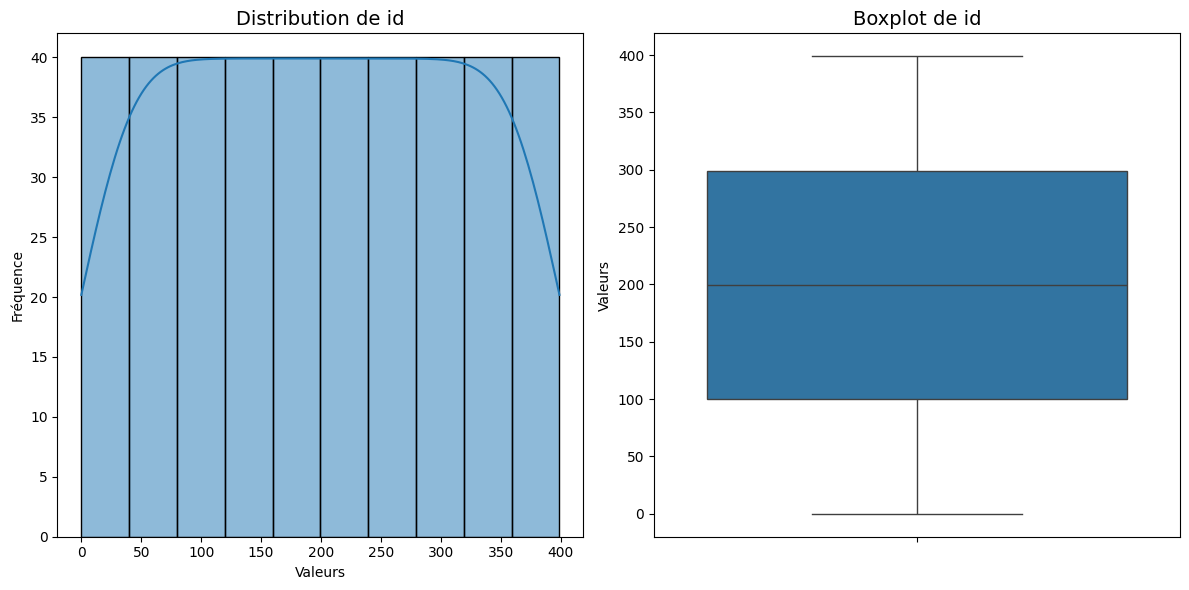

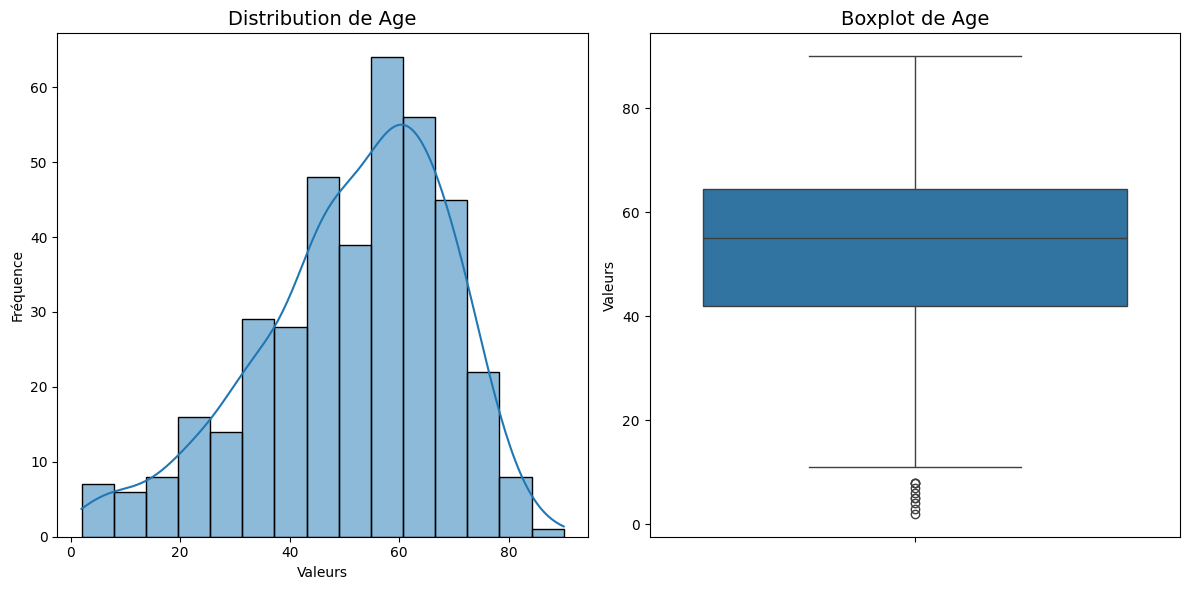

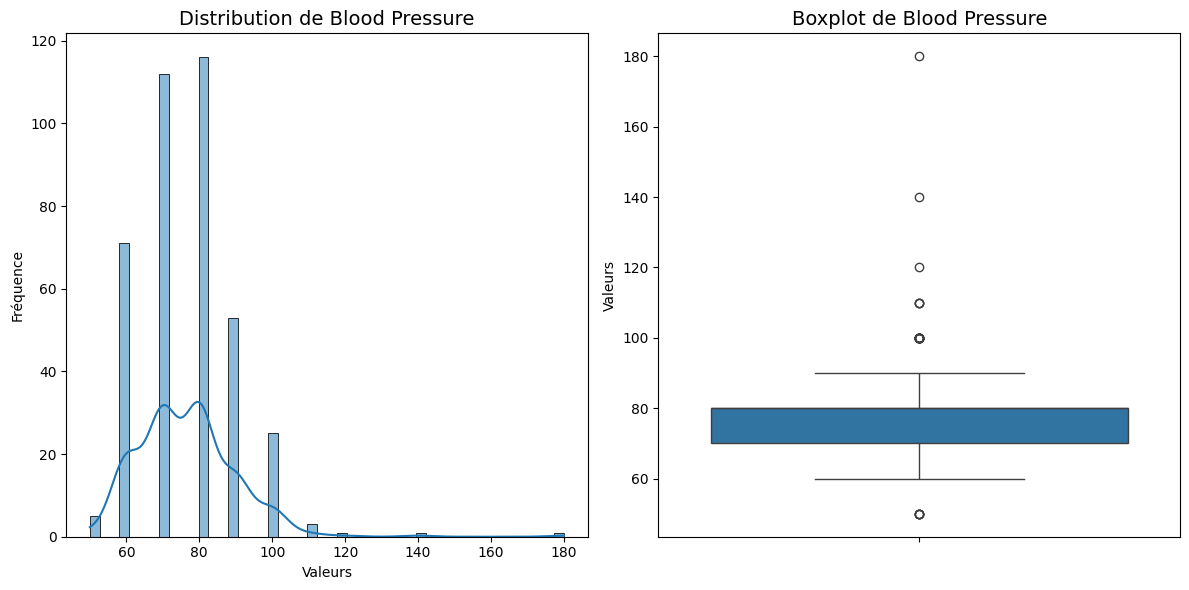

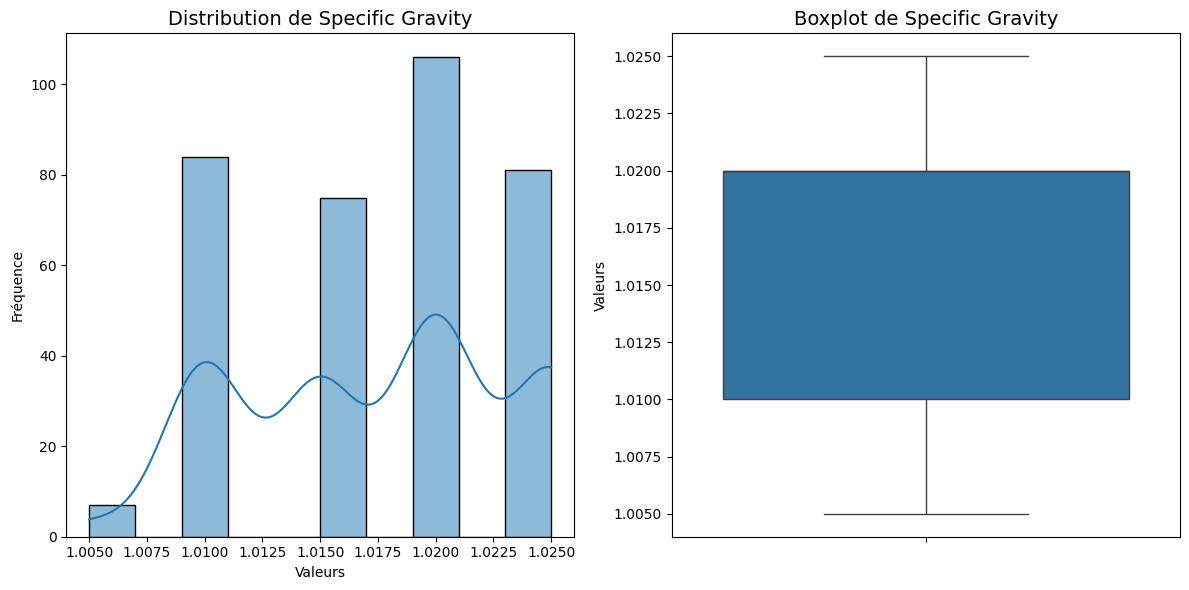

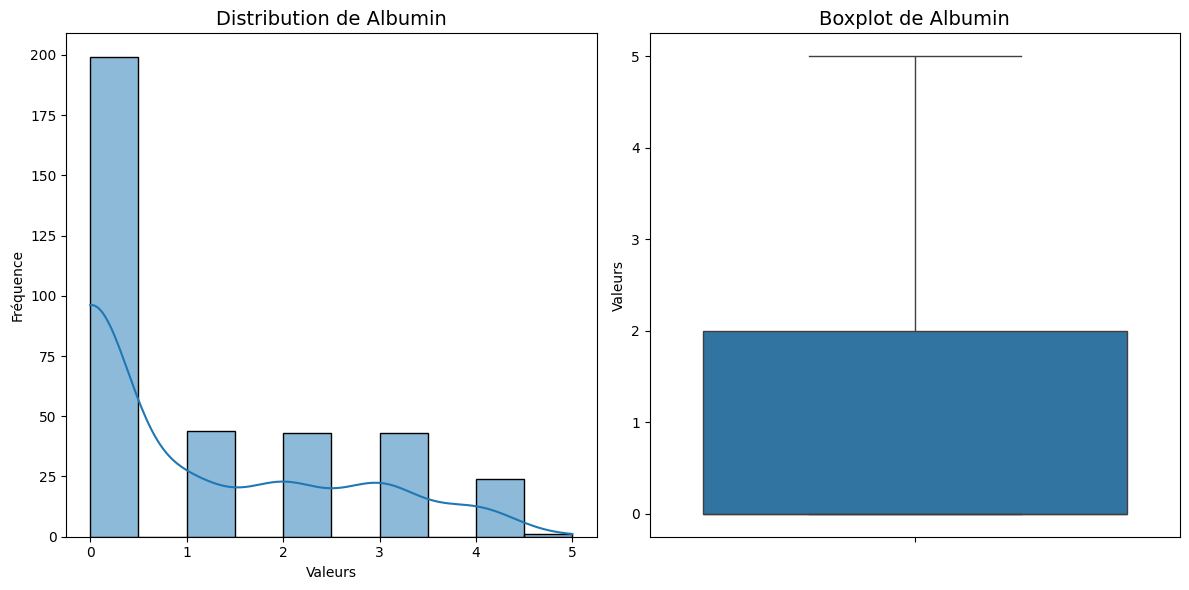

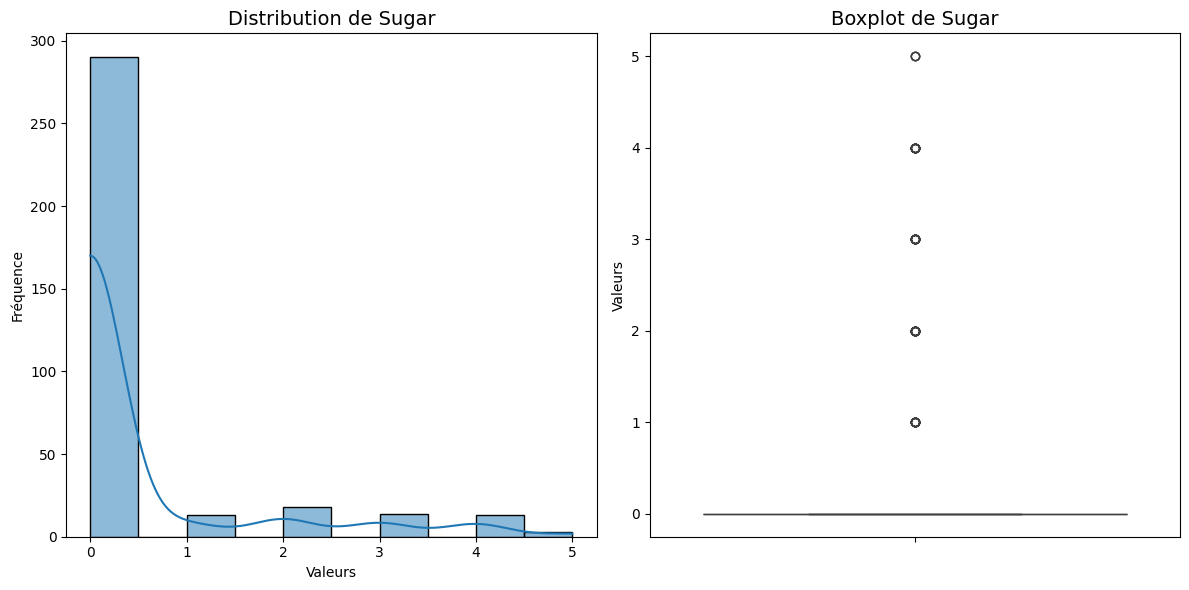

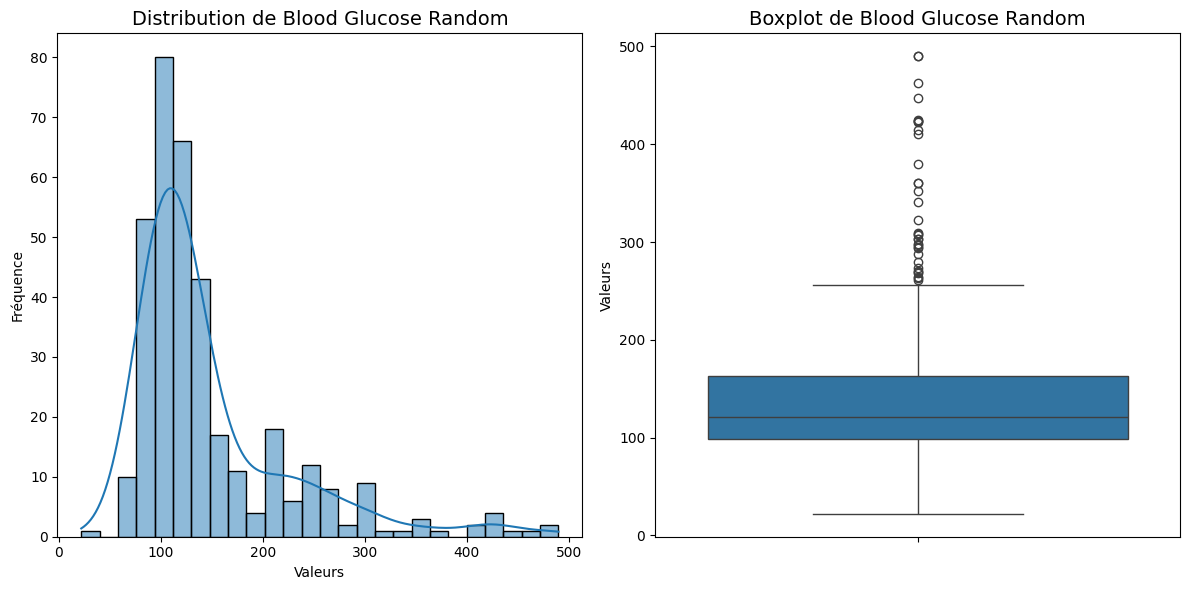

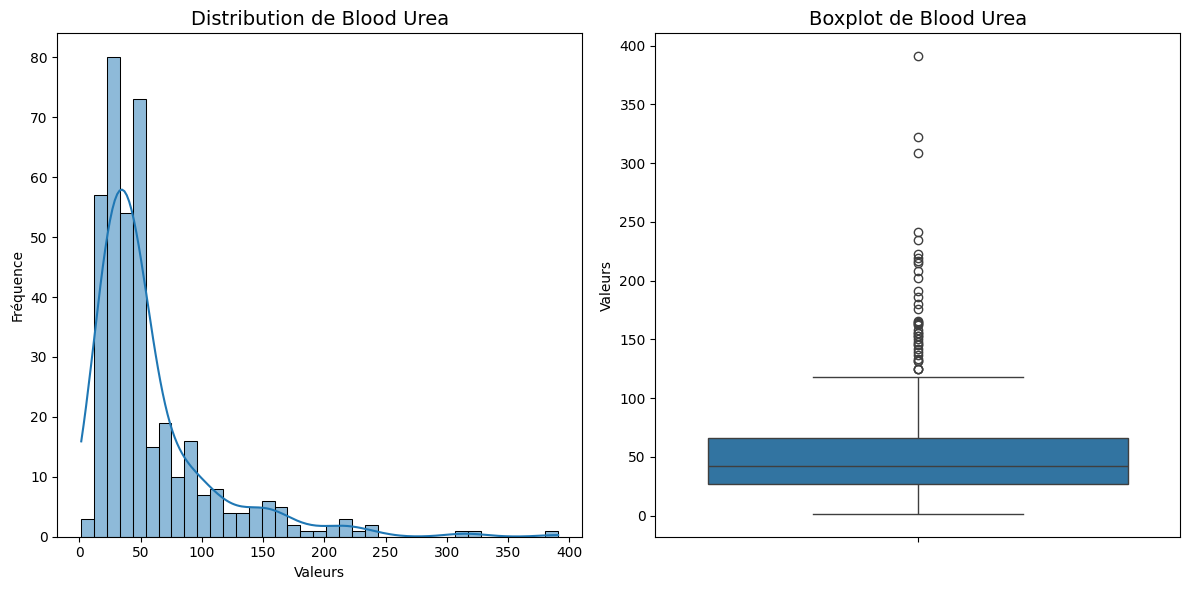

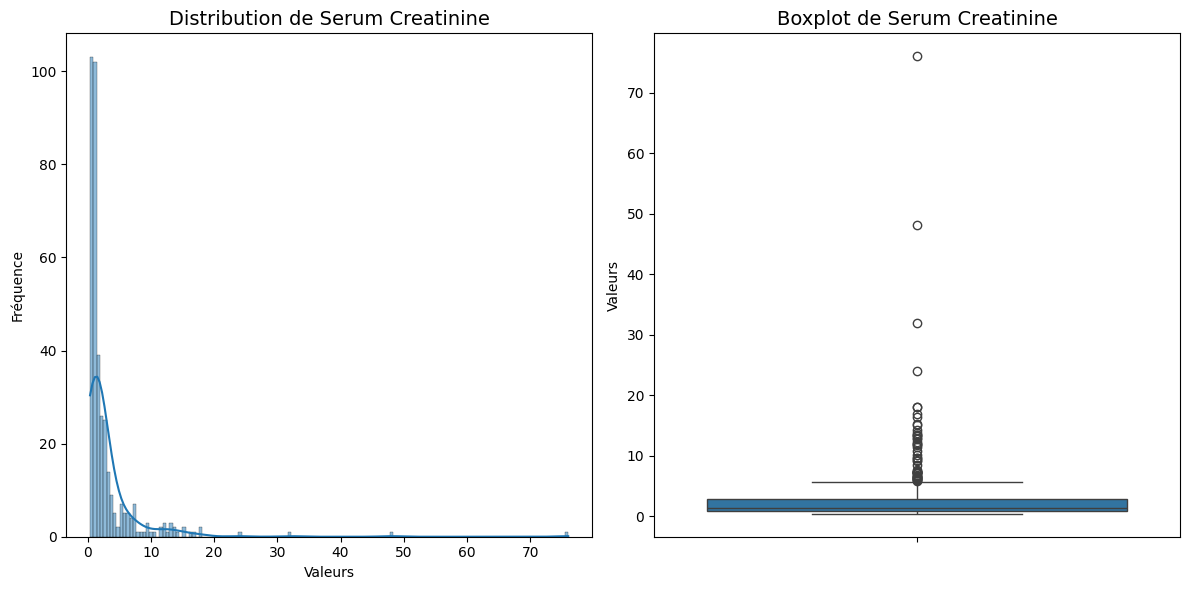

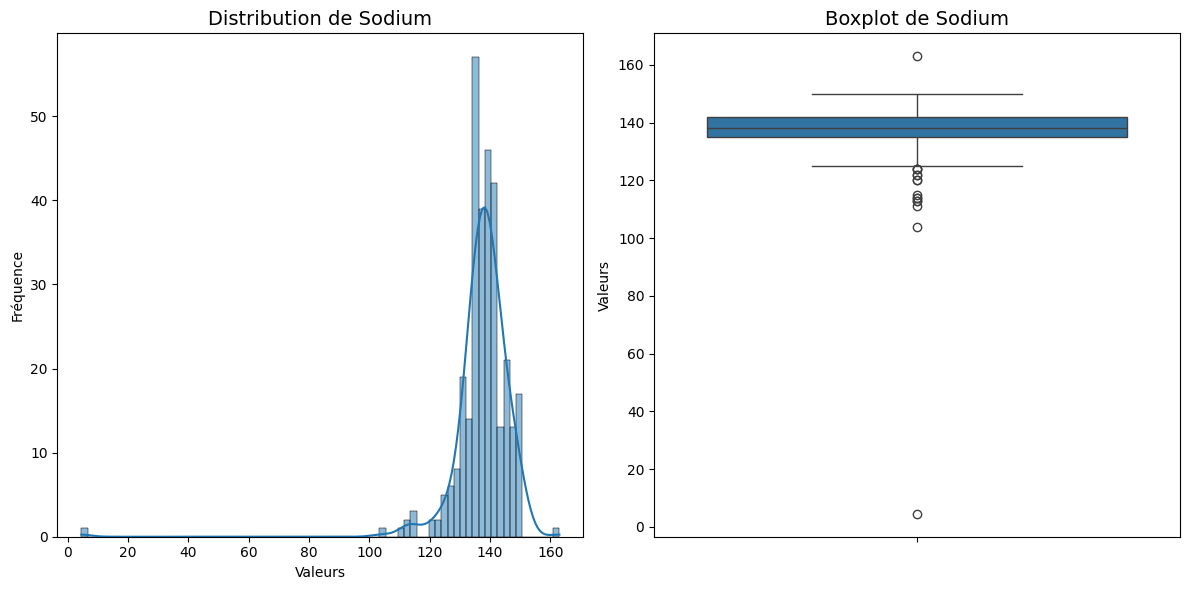

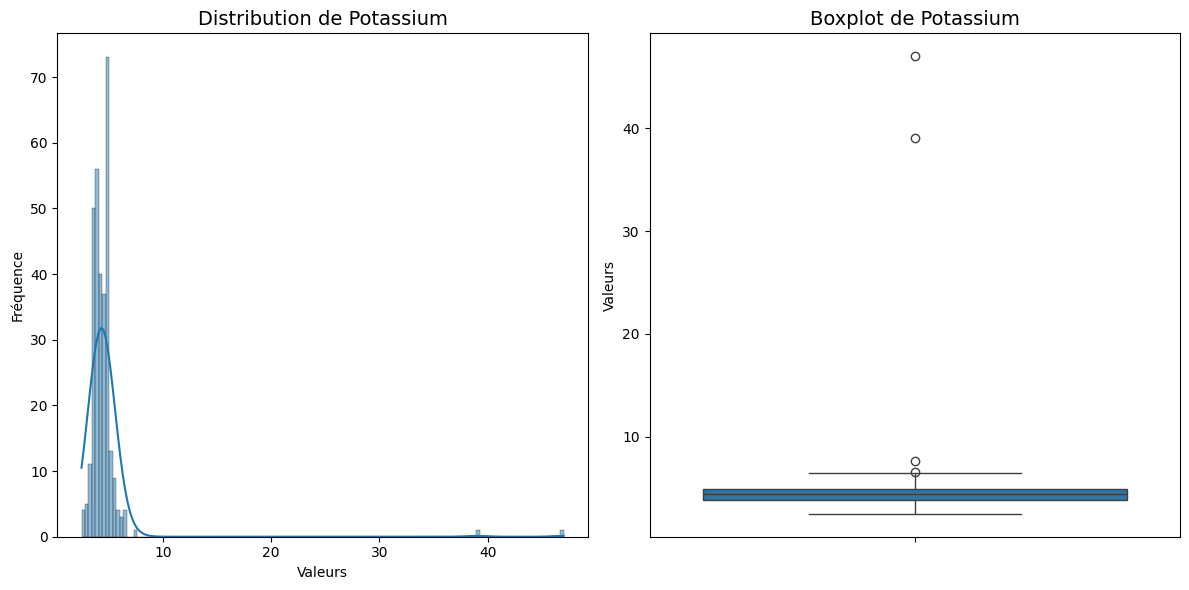

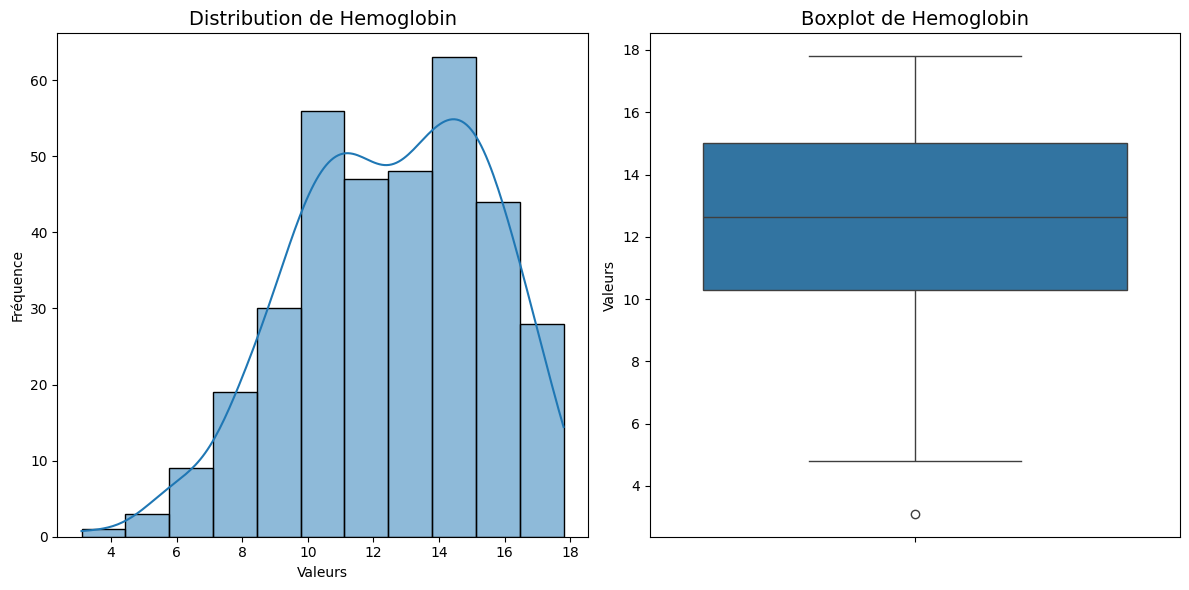

In [7]:
# 3. Analyse des variables numériques
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in numeric_cols:
    print(f"\nStatistiques pour '{col}':")
    print(df_clean[col].describe())

    # Histogramme et boxplot
    plt.figure(figsize=(12, 6))

    # Histogramme
    plt.subplot(1, 2, 1)
    sns.histplot(df_clean[col].dropna(), kde=True)
    plt.title(f'Distribution de {col}', fontsize=14)
    plt.xlabel('Valeurs')
    plt.ylabel('Fréquence')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_clean[col].dropna())
    plt.title(f'Boxplot de {col}', fontsize=14)
    plt.ylabel('Valeurs')

    plt.tight_layout()
    plt.savefig(f'numeric_{col}.png')


## Correlation analysis

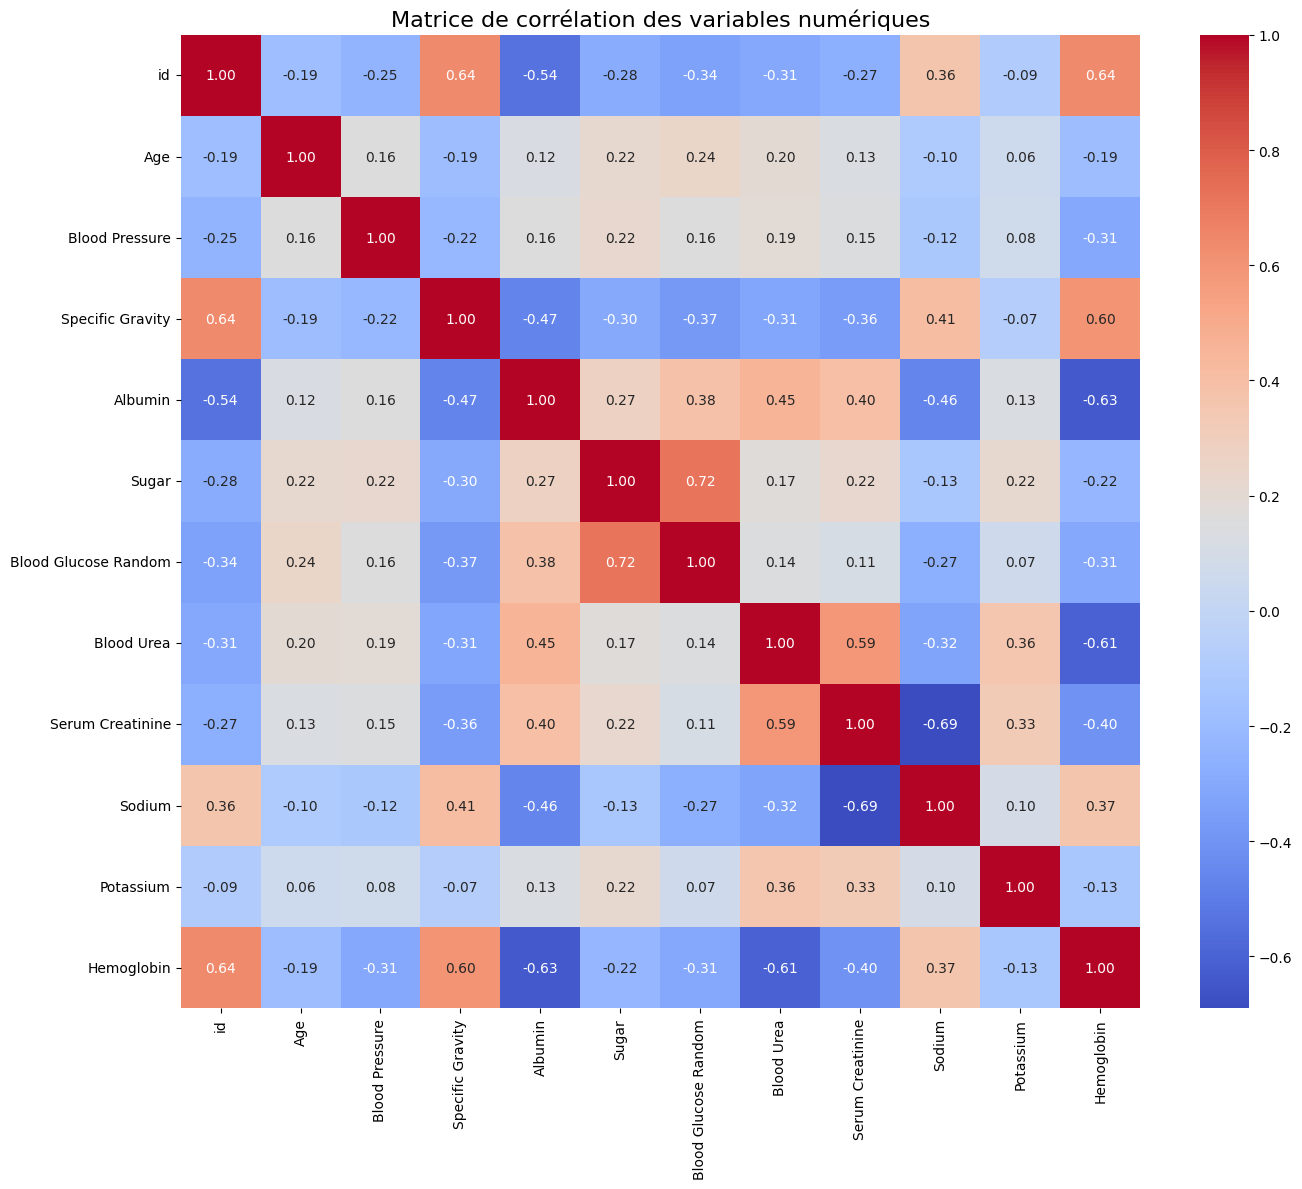

In [8]:
# 5. Analyse des corrélations
correlation_matrix = df_clean.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de corrélation des variables numériques', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_matrix.png')


# Pre-Processing

1. Conversion des données catégorielles en binaires
D'abord, nous identifions les colonnes qui contiennent des données catégorielles et les convertissons en valeurs binaires (0 et 1):

J'ai créé un dictionnaire binary_mappings qui contient les règles de conversion pour chaque colonne catégorielle connue dans le dataset kidney-disease:

Pour les colonnes comme 'rbc', 'pc': "normal" devient 1, "abnormal" devient 0
Pour 'pcc', 'ba': "present" devient 1, "notpresent" devient 0
Pour 'htn', 'dm', 'cad', 'pe', 'ane': "yes" devient 1, "no" devient 0
Pour 'appet': "good" devient 1, "poor" devient 0
Pour 'class' (la variable cible): "ckd" (chronic kidney disease) devient 1, "notckd" devient 0


Les valeurs sont d'abord nettoyées (espaces supprimés, conversion en minuscules) pour assurer la cohérence
La méthode map() de pandas est ensuite utilisée pour effectuer la conversion selon le dictionnaire défini

Cette conversion transforme les données textuelles en valeurs numériques, ce qui est essentiel pour la plupart des algorithmes de machine learning.
2. Imputation des valeurs manquantes
Après avoir converti toutes les colonnes en format numérique, nous appliquons une stratégie d'imputation en cascade pour les valeurs manquantes:

Essai avec la médiane:

Pour chaque colonne, nous calculons la médiane des valeurs existantes
La médiane est préférée à la moyenne car elle est moins sensible aux valeurs extrêmes
Si la médiane peut être calculée (assez de valeurs disponibles), nous l'utilisons pour remplacer toutes les valeurs manquantes de cette colonne


Fallback à la moyenne:

Si la médiane est elle-même NaN (peut arriver si trop peu de valeurs sont disponibles), nous essayons avec la moyenne
La moyenne est calculée et utilisée pour remplacer les valeurs manquantes


Dernier recours avec valeur par défaut:

Si ni la médiane ni la moyenne ne peuvent être calculées (par exemple, si presque toutes les valeurs sont manquantes), nous utilisons 0 comme valeur par défaut


Cas spécial des colonnes entièrement vides:

Pour les colonnes où toutes les valeurs sont manquantes, nous remplaçons directement par 0



Cette approche est progressive et adaptative, ce qui permet de traiter efficacement différents types de colonnes et différents niveaux de données manquantes.
Avantages de cette méthode

Elle est robuste face aux colonnes problématiques (comme celles mentionnées dans l'erreur : 'rbc', 'pc', 'pcc', 'ba', etc.)
Elle préserve la distribution générale des données en utilisant prioritairement la médiane
Elle garantit qu'aucune valeur manquante ne subsiste dans le dataset final, ce qui est essentiel pour la plupart des algorithmes de machine learning
La conversion binaire préalable simplifie l'interprétation future des résultats


In [9]:
# Remplacer les valeurs problématiques par NaN
df = df.replace(['\t', '?', '', 'nan', 'NaN', 'na'], np.nan)

## Conversion of categorical data into numerical

In [10]:
# Première étape : Convertir les colonnes catégorielles en binaire
# Liste des colonnes catégorielles courantes dans le dataset kidney-disease
binary_mappings = {
    'rbc': {'normal': 1, 'abnormal': 0},
    'pc': {'normal': 1, 'abnormal': 0},
    'pcc': {'present': 1, 'notpresent': 0},
    'ba': {'present': 1, 'notpresent': 0},
    'htn': {'yes': 1, 'no': 0},
    'dm': {'yes': 1, 'no': 0},
    'cad': {'yes': 1, 'no': 0},
    'appet': {'good': 1, 'poor': 0},
    'pe': {'yes': 1, 'no': 0},
    'ane': {'yes': 1, 'no': 0}
}

# Vérifier si 'class' ou 'classification' existe dans le dataframe
if 'class' in df.columns:
    binary_mappings['class'] = {'ckd': 1, 'notckd': 0}
elif 'classification' in df.columns:
    binary_mappings['classification'] = {'ckd': 1, 'notckd': 0}

# Nettoyer et convertir les colonnes textuelles + mapping binaire
for col in df.select_dtypes(include=['object']).columns:
    if not df[col].isna().all():
        df[col] = df[col].str.strip().str.lower()

        # Si la colonne fait partie des colonnes à mapper
        if col in binary_mappings:
            df[col] = df[col].map(binary_mappings[col])
            print(f"Conversion binaire pour {col} - valeurs NaN: {df[col].isna().sum()}")
        else:
            # Essayer de convertir en numérique si ce n'est pas une colonne binaire
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                print(f"Colonne {col} convertie en numérique")
            except Exception as e:
                print(f"Échec de conversion numérique pour {col}: {e}")


Colonne Red Blood Cells convertie en numérique
Colonne Pus Cell convertie en numérique
Colonne Pus Cell Clumps convertie en numérique
Colonne Bacteria convertie en numérique
Colonne Packed Cell Volume convertie en numérique
Colonne White Blood Cells Count convertie en numérique
Colonne Red Blood Cells Count convertie en numérique
Colonne Hypertension convertie en numérique
Colonne Diabetes Mellitus convertie en numérique
Colonne Coronary Artery Disease convertie en numérique
Colonne Appetite convertie en numérique
Colonne Pedal Edema convertie en numérique
Colonne Anemia convertie en numérique
Conversion binaire pour classification - valeurs NaN: 0


## Data imputation

In [11]:
for col in df.columns:
    if not df[col].dropna().empty:
        median_value = df[col].median()
        if pd.notna(median_value):
            df[col] = df[col].fillna(median_value)
            print(f"Colonne {col} - imputation avec médiane: {median_value}")
        else:
            mean_value = df[col].mean()
            if pd.notna(mean_value):
                df[col] = df[col].fillna(mean_value)
                print(f"Colonne {col} - imputation avec moyenne: {mean_value}")
            else:
                df[col] = df[col].fillna(0)
                print(f"Colonne {col} - imputation avec 0 (fallback)")
    else:
        df[col] = df[col].fillna(0)
        print(f"Colonne {col} entièrement vide - remplacée par 0")


Colonne id - imputation avec médiane: 199.5
Colonne Age - imputation avec médiane: 55.0
Colonne Blood Pressure - imputation avec médiane: 80.0
Colonne Specific Gravity - imputation avec médiane: 1.02
Colonne Albumin - imputation avec médiane: 0.0
Colonne Sugar - imputation avec médiane: 0.0
Colonne Red Blood Cells entièrement vide - remplacée par 0
Colonne Pus Cell entièrement vide - remplacée par 0
Colonne Pus Cell Clumps entièrement vide - remplacée par 0
Colonne Bacteria entièrement vide - remplacée par 0
Colonne Blood Glucose Random - imputation avec médiane: 121.0
Colonne Blood Urea - imputation avec médiane: 42.0
Colonne Serum Creatinine - imputation avec médiane: 1.3
Colonne Sodium - imputation avec médiane: 138.0
Colonne Potassium - imputation avec médiane: 4.4
Colonne Hemoglobin - imputation avec médiane: 12.649999999999999
Colonne Packed Cell Volume - imputation avec médiane: 40.0
Colonne White Blood Cells Count - imputation avec médiane: 8000.0
Colonne Red Blood Cells Count 

## Verifications

In [12]:


# Vérifier le résultat après nettoyage
print("\nAperçu des données après nettoyage:")
print(df.head())
print("\nInformations après nettoyage:")
print(df.info())
print("\nVérification des valeurs manquantes restantes:")
print(df.isnull().sum())

# Analyse statistique finale
print("\nStatistiques descriptives après conversion et imputation:")
print(df.describe())

# Sauvegarder le dataset nettoyé
df.to_csv('kidney_disease_cleaned_binary.csv', index=False)
print("\nFichier nettoyé sauvegardé sous 'kidney_disease_cleaned_binary.csv'")

# Option: afficher la distribution des valeurs pour vérifier
print("\nDistribution des valeurs pour quelques colonnes principales:")
for col in df.columns[:5]:  # Limité aux 5 premières colonnes
    print(f"\nDistribution de {col}:")
    print(df[col].value_counts())

# Vérification spécifique de la variable cible (class ou classification)
if 'class' in df.columns:
    print("\nDistribution de la variable cible 'class':")
    print(df['class'].value_counts())
elif 'classification' in df.columns:
    print("\nDistribution de la variable cible 'classification':")
    print(df['classification'].value_counts())


Aperçu des données après nettoyage:
   id   Age  Blood Pressure  Specific Gravity  Albumin  Sugar  \
0   0  48.0            80.0             1.020      1.0    0.0   
1   1   7.0            50.0             1.020      4.0    0.0   
2   2  62.0            80.0             1.010      2.0    3.0   
3   3  48.0            70.0             1.005      4.0    0.0   
4   4  51.0            80.0             1.010      2.0    0.0   

   Red Blood Cells  Pus Cell  Pus Cell Clumps  Bacteria  ...  \
0              0.0       0.0              0.0       0.0  ...   
1              0.0       0.0              0.0       0.0  ...   
2              0.0       0.0              0.0       0.0  ...   
3              0.0       0.0              0.0       0.0  ...   
4              0.0       0.0              0.0       0.0  ...   

   Packed Cell Volume  White Blood Cells Count  Red Blood Cells Count  \
0                44.0                   7800.0                    5.2   
1                38.0                   6

Supprimer la colone Id  celle -ci me causiat des problémes sur Knn donc je la supprimer

In [13]:
# Supprimer la colonne 'id'
df = df.drop('id', axis=1)
print("Colonne 'id' supprimée. Dimensions du dataset:", df.shape)
df

Colonne 'id' supprimée. Dimensions du dataset: (400, 25)


,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell Clumps,Bacteria,Blood Glucose Random,...,Packed Cell Volume,White Blood Cells Count,Red Blood Cells Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,classification
0,48.0,80.0,1.020,1.0,0.0,0.0,0.0,0.0,0.0,121.0,...,44.0,7800.0,5.2,0.0,0.0,0.0,0.0,0.0,0.0,1
1,7.0,50.0,1.020,4.0,0.0,0.0,0.0,0.0,0.0,121.0,...,38.0,6000.0,4.8,0.0,0.0,0.0,0.0,0.0,0.0,1
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,...,31.0,7500.0,4.8,0.0,0.0,0.0,0.0,0.0,0.0,1
3,48.0,70.0,1.005,4.0,0.0,0.0,0.0,0.0,0.0,117.0,...,32.0,6700.0,3.9,0.0,0.0,0.0,0.0,0.0,0.0,1
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,...,35.0,7300.0,4.6,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,140.0,...,47.0,6700.0,4.9,0.0,0.0,0.0,0.0,0.0,0.0,0
396,42.0,70.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,75.0,...,54.0,7800.0,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0
397,12.0,80.0,1.020,0.0,0.0,0.0,0.0,0.0,0.0,100.0,...,49.0,6600.0,5.4,0.0,0.0,0.0,0.0,0.0,0.0,0
398,17.0,60.0,1.025,0.0,0.0,0.0,0.0,0.0,0.0,114.0,...,51.0,7200.0,5.9,0.0,0.0,0.0,0.0,0.0,0.0,0


Ce script Python permet d'explorer en profondeur un dataset pour un projet de machine learning. En tant qu'étudiant, j'ai développé ce code pour analyser rapidement la structure et les caractéristiques d'un jeu de données avant de commencer le prétraitement et la modélisation.
Fonctionnalités
1. Informations générales
Le code commence par afficher les dimensions du dataset (nombre de lignes et de colonnes) et un aperçu des premières lignes. Cela me donne une vue d'ensemble des données avec lesquelles je vais travailler.
2. Analyse des colonnes et types de données
J'affiche ensuite la liste complète des colonnes avec leurs types de données respectifs. Cette étape est cruciale pour identifier quelles variables sont numériques, catégorielles, etc.
3. Analyse détaillée des valeurs uniques
Pour chaque colonne du dataset:

J'affiche le nombre de valeurs uniques
Si la colonne contient peu de valeurs uniques (≤ 10), je les affiche pour une inspection rapide
J'affiche la distribution des valeurs pour comprendre leur répartition
Je signale automatiquement les colonnes binaires qui pourraient servir de variables cibles

4. Identification des variables cibles potentielles
Le code recherche intelligemment les colonnes qui pourraient servir de variables cibles pour un problème de classification:

Colonnes avec un nombre limité de valeurs uniques (2-5)
Variables numériques discrètes
Affichage de leur distribution pour évaluer l'équilibre des classes

5. Vérification spécifique de la variable 'classification'
Si une colonne nommée 'classification' existe (nom commun pour une variable cible):

J'analyse spécifiquement cette colonne
Je vérifie qu'elle contient plus d'une valeur (sinon, elle ne peut pas servir à la classification)
J'affiche sa distribution détaillée

6. Recherche de colonnes liées à une classe
Le code recherche également les colonnes contenant 'class' dans leur nom, qui sont souvent des variables cibles.
7. Conclusion et recommandations
Enfin, je fournis une conclusion avec:

La recommandation de la meilleure variable cible identifiée
Une préférence pour les variables avec une distribution équilibrée des classes
Un avertissement si aucune variable cible appropriée n'est identifiée



In [14]:
# 1. Analyse des valeurs uniques pour chaque colonne
print("\n--- Valeurs uniques par colonne ---")
for col in df.columns:
    unique_vals = df[col].unique()
    n_unique = len(unique_vals)
    print(f"\nColonne: {col}")
    print(f"Nombre de valeurs uniques: {n_unique}")

    # Si peu de valeurs uniques, les afficher
    if n_unique <= 10:
        print("Valeurs uniques:", unique_vals)

    # Distribution des valeurs
    val_counts = df[col].value_counts()
    print("Distribution:")
    print(val_counts)

    # Vérifier si la colonne pourrait être une variable cible binaire
    if n_unique == 2:
        print("Cette colonne pourrait être une variable cible binaire")



--- Valeurs uniques par colonne ---

Colonne: Age
Nombre de valeurs uniques: 76
Distribution:
Age
55.0    21
60.0    19
65.0    17
48.0    12
50.0    12
        ..
90.0     1
2.0      1
78.0     1
22.0     1
79.0     1
Name: count, Length: 76, dtype: int64

Colonne: Blood Pressure
Nombre de valeurs uniques: 10
Valeurs uniques: [ 80.  50.  70.  90. 100.  60. 110. 140. 180. 120.]
Distribution:
Blood Pressure
80.0     128
70.0     112
60.0      71
90.0      53
100.0     25
50.0       5
110.0      3
140.0      1
180.0      1
120.0      1
Name: count, dtype: int64

Colonne: Specific Gravity
Nombre de valeurs uniques: 5
Valeurs uniques: [1.02  1.01  1.005 1.015 1.025]
Distribution:
Specific Gravity
1.020    153
1.010     84
1.025     81
1.015     75
1.005      7
Name: count, dtype: int64

Colonne: Albumin
Nombre de valeurs uniques: 6
Valeurs uniques: [1. 4. 2. 3. 0. 5.]
Distribution:
Albumin
0.0    245
1.0     44
3.0     43
2.0     43
4.0     24
5.0      1
Name: count, dtype: int64

Colonne

In [15]:
# 2. Recherche des colonnes qui pourraient être des variables cibles
potential_targets = []
for col in df.columns:
    # Vérifier si la colonne a peu de valeurs uniques (idéal pour classification)
    n_unique = df[col].nunique()
    if 1 < n_unique <= 5:  # Entre 2 et 5 classes
        # Vérifier si les valeurs sont numériques et discrètes
        if df[col].dtype in ['int64', 'float64']:
            # Vérifier si les valeurs sont discrètes (pas de valeurs continuesMissingData.com)
            if len(df[col].value_counts()) <= 5:
                potential_targets.append(col)

print("\n--- Colonnes potentielles pour la variable cible ---")
for col in potential_targets:
    print(f"Colonne: {col}")
    print("Valeurs uniques:", df[col].unique())
    print("Distribution:")
    print(df[col].value_counts())
    print()


--- Colonnes potentielles pour la variable cible ---
Colonne: Specific Gravity
Valeurs uniques: [1.02  1.01  1.005 1.015 1.025]
Distribution:
Specific Gravity
1.020    153
1.010     84
1.025     81
1.015     75
1.005      7
Name: count, dtype: int64

Colonne: classification
Valeurs uniques: [1 0]
Distribution:
classification
1    250
0    150
Name: count, dtype: int64



In [16]:
# 3. Vérification spécifique de la variable 'classification'
if 'classification' in df.columns:
    print("\n--- Analyse spécifique de la variable 'classification' ---")
    print("Valeurs uniques:", df['classification'].unique())
    print("Distribution:")
    print(df['classification'].value_counts())

    # Si 'classification' ne contient qu'une seule valeur, c'est un problème
    if df['classification'].nunique() == 1:
        print("ALERTE: La colonne 'classification' ne contient qu'une seule valeur!")
        print("Elle ne peut pas être utilisée comme variable cible pour un problème de classification.")


--- Analyse spécifique de la variable 'classification' ---
Valeurs uniques: [1 0]
Distribution:
classification
1    250
0    150
Name: count, dtype: int64


In [17]:
# 4. Vérifier la présence d'une colonne 'class' ou similaire
class_cols = [col for col in df.columns if 'class' in col.lower()]
if class_cols:
    print("\n--- Colonnes contenant 'class' dans leur nom ---")
    for col in class_cols:
        print(f"Colonne: {col}")
        print("Valeurs uniques:", df[col].unique())
        print("Distribution:")
        print(df[col].value_counts())
        print()

# 8. Conclusion et recommandations
print("\n--- Conclusion et recommandations ---")
if potential_targets:
    best_target = potential_targets[0]  # Par défaut, prenons la première
    for col in potential_targets:
        # Préférer les colonnes avec distribution plus équilibrée
        if df[col].nunique() > 1 and df[col].value_counts().min() > df[best_target].value_counts().min():
            best_target = col

    print(f"La meilleure variable cible semble être '{best_target}'")
    print("Distribution:")
    print(df[best_target].value_counts())
else:
    print("Aucune colonne appropriée pour une variable cible n'a été identifiée.")
    print("Vérifiez le processus de prétraitement des données.")


--- Colonnes contenant 'class' dans leur nom ---
Colonne: classification
Valeurs uniques: [1 0]
Distribution:
classification
1    250
0    150
Name: count, dtype: int64


--- Conclusion et recommandations ---
La meilleure variable cible semble être 'classification'
Distribution:
classification
1    250
0    150
Name: count, dtype: int64


In [18]:
X = df.drop('classification', axis=1)  # Replace 'class' with 'classification'
y = df['classification']  # Replace 'class' with 'classification'

# Create and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

importances = rf_model.feature_importances_
# Use X.columns instead of X_train.columns
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

print("\n--- Importance des variables ---")
print(feature_importance)


--- Importance des variables ---
Hemoglobin                 0.255403
Packed Cell Volume         0.171087
Serum Creatinine           0.127394
Specific Gravity           0.105804
Albumin                    0.070379
Red Blood Cells Count      0.070299
Blood Urea                 0.042916
Sodium                     0.042251
Blood Glucose Random       0.041057
Age                        0.016694
Blood Pressure             0.015287
Sugar                      0.014854
White Blood Cells Count    0.014153
Potassium                  0.012422
Red Blood Cells            0.000000
Pus Cell                   0.000000
Pus Cell Clumps            0.000000
Bacteria                   0.000000
Hypertension               0.000000
Diabetes Mellitus          0.000000
Coronary Artery Disease    0.000000
Appetite                   0.000000
Pedal Edema                0.000000
Anemia                     0.000000
dtype: float64


In [19]:

importances = rf_model.feature_importances_
# Use X.columns instead of X_train.columns
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

print("\n--- Importance des variables ---")
print(feature_importance)

# Calculate importances in percentage
importances_percent = importances * 100

# Create a DataFrame to display the results
feature_importance_df = pd.DataFrame({
    'Index': range(len(X.columns)),
    'Caractéristique': X.columns,
    'Importance (%)': importances_percent
}).sort_values('Importance (%)', ascending=False)



--- Importance des variables ---
Hemoglobin                 0.255403
Packed Cell Volume         0.171087
Serum Creatinine           0.127394
Specific Gravity           0.105804
Albumin                    0.070379
Red Blood Cells Count      0.070299
Blood Urea                 0.042916
Sodium                     0.042251
Blood Glucose Random       0.041057
Age                        0.016694
Blood Pressure             0.015287
Sugar                      0.014854
White Blood Cells Count    0.014153
Potassium                  0.012422
Red Blood Cells            0.000000
Pus Cell                   0.000000
Pus Cell Clumps            0.000000
Bacteria                   0.000000
Hypertension               0.000000
Diabetes Mellitus          0.000000
Coronary Artery Disease    0.000000
Appetite                   0.000000
Pedal Edema                0.000000
Anemia                     0.000000
dtype: float64


# Model Training

Classification entre els echantillons d'entrainenemnt et ceux de test

In [20]:
# 1. Vérification de la variable cible
print("Distribution de la variable cible 'classification':")
print(df['classification'].value_counts())
print(f"Pourcentage: {df['classification'].value_counts(normalize=True) * 100}")

Distribution de la variable cible 'classification':
classification
1    250
0    150
Name: count, dtype: int64
Pourcentage: classification
1    62.5
0    37.5
Name: proportion, dtype: float64


In [21]:
# 2. Séparation des features et de la variable cible
X = df.drop('classification', axis=1)
y = df['classification']

In [22]:
# 3. Division en ensembles d'entraînement et de test (70% / 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [23]:
# 4. Sauvegarde des ensembles d'entraînement et de test
X_train.to_csv('X_train.csv', index=False)
pd.Series(y_train).to_csv('y_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
pd.Series(y_test).to_csv('y_test.csv', index=False)

In [24]:
print("\nDivision des données terminée.")
print(f"Ensemble d'entraînement : {X_train.shape[0]} échantillons ({X_train.shape[1]} caractéristiques)")
print(f"Ensemble de test : {X_test.shape[0]} échantillons ({X_test.shape[1]} caractéristiques)")
print("\nDistribution dans l'ensemble d'entraînement:")
print(y_train.value_counts())
print(f"Pourcentage: {y_train.value_counts(normalize=True) * 100}")
print("\nDistribution dans l'ensemble de test:")
print(y_test.value_counts())
print(f"Pourcentage: {y_test.value_counts(normalize=True) * 100}")


Division des données terminée.
Ensemble d'entraînement : 280 échantillons (24 caractéristiques)
Ensemble de test : 120 échantillons (24 caractéristiques)

Distribution dans l'ensemble d'entraînement:
classification
1    175
0    105
Name: count, dtype: int64
Pourcentage: classification
1    62.5
0    37.5
Name: proportion, dtype: float64

Distribution dans l'ensemble de test:
classification
1    75
0    45
Name: count, dtype: int64
Pourcentage: classification
1    62.5
0    37.5
Name: proportion, dtype: float64


Dans le cadre de notre projet de prédiction des maladies rénales chroniques (CKD), nous avons sélectionné trois algorithmes de classification ayant des approches fondamentalement différentes. Cette diversité nous permet d'explorer différentes façons d'aborder le problème et de comparer leurs performances respectives.
Justification des modèles sélectionnés
1. Régression Logistique
Pourquoi ce modèle ?

Interprétabilité : La régression logistique fournit des coefficients facilement interprétables, permettant de comprendre l'influence de chaque facteur médical sur le risque de maladie rénale.
Efficacité avec des frontières linéaires : Bien que simple, ce modèle est souvent très efficace lorsque la relation entre les variables et la classe cible peut être approximée linéairement.
Robustesse : Moins susceptible au sur-apprentissage par rapport aux modèles plus complexes, surtout avec des datasets de taille modérée.
Rapidité : Exécution rapide tant pour l'entraînement que pour les prédictions, ce qui est crucial dans un contexte médical où les décisions doivent parfois être prises rapidement.
Probabilités calibrées : Fournit des probabilités bien calibrées, ce qui est essentiel en médecine où l'incertitude de la prédiction doit être quantifiée.

2. Random Forest
Pourquoi ce modèle ?

Capture de relations complexes : Capable de modéliser des interactions non-linéaires complexes entre les variables médicales, qui sont fréquentes dans les données physiologiques.
Robustesse aux valeurs aberrantes : Les données médicales contiennent souvent des cas atypiques ou extrêmes que le Random Forest gère bien.
Importance des variables : Fournit une mesure de l'importance des caractéristiques, permettant d'identifier les facteurs médicaux les plus critiques pour le diagnostic.
Réduction du risque de sur-apprentissage : Grâce à l'agrégation de multiples arbres entraînés sur des sous-ensembles différents des données.
Performance élevée : Généralement parmi les algorithmes les plus performants pour les problèmes de classification complexes.

3. K-Nearest Neighbors (KNN)
Pourquoi ce modèle ?

Approche non-paramétrique : Ne fait aucune hypothèse sur la distribution sous-jacente des données, ce qui est avantageux pour les données médicales où les relations peuvent être difficiles à modéliser explicitement.
Intuitivité : Le concept de "similarité" avec d'autres patients est intuitif et reflète la démarche médicale de comparaison avec des cas connus.
Adaptabilité locale : S'adapte aux structures locales des données, permettant de capturer des sous-groupes spécifiques de patients présentant des caractéristiques similaires.
Pas de phase d'entraînement : Particulièrement utile lorsque de nouvelles données sont régulièrement ajoutées, car le modèle s'adapte naturellement.
Efficacité prouvée : Bien que simple, KNN peut être très efficace pour des problèmes médicaux où la proximité entre les patients dans l'espace des caractéristiques est significative.


In [25]:
X = df.drop('classification', axis=1)
y = df['classification']

In [26]:
# Split en 70% train / 30% test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (280, 24), Test: (120, 24)


In [27]:
# === 2. NORMALISATION ===

scaler = StandardScaler()
numeric_features = X_train.select_dtypes(include=['number']).columns

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

In [28]:

# === 3. RANDOM FOREST (SUR TOUTES LES COLONNES) ===

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Prédictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Accuracy & rapport de classification
print("\nRandom Forest - Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nRapport de classification - Random Forest:\n", classification_report(y_test, y_pred_rf))



Random Forest - Accuracy: 0.9916666666666667

Rapport de classification - Random Forest:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.99      1.00      0.99        75

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



In [29]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
y_prob_lr = model_lr.predict_proba(X_test)[:, 1]

print("\nRégression Logistique - Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nRapport de classification - Régression Logistique:\n", classification_report(y_test, y_pred_lr))


Régression Logistique - Accuracy: 0.9333333333333333

Rapport de classification - Régression Logistique:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        45
           1       0.95      0.95      0.95        75

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.93      0.93      0.93       120



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)
y_prob_knn = model_knn.predict_proba(X_test)[:, 1]

print("\nKNN - Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nRapport de classification - KNN:\n", classification_report(y_test, y_pred_knn))



KNN - Accuracy: 0.7416666666666667

Rapport de classification - KNN:
               precision    recall  f1-score   support

           0       0.63      0.76      0.69        45
           1       0.83      0.73      0.78        75

    accuracy                           0.74       120
   macro avg       0.73      0.74      0.73       120
weighted avg       0.76      0.74      0.75       120



In [31]:
# === 4. COURBE ROC ===

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)


## Cross Validation

In [32]:
model = RandomForestClassifier()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kfold, scoring='f1')
print("Cross-validation scores:", scores)
print("Average accuracy:", scores.mean())

Cross-validation scores: [0.99029126 0.98989899 1.         1.         0.94623656]
Average accuracy: 0.9852853622349395


# Evaluation

In [33]:
# Calculer les métriques ROC pour les visualisations
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Évaluation des modèles
print("Régression Logistique - Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Random Forest - Accuracy:", accuracy_score(y_test, y_pred_rf))
print("KNN - Accuracy:", accuracy_score(y_test, y_pred_knn))

# Afficher les rapports de classification
print("\nRapport de classification - Régression Logistique:\n", classification_report(y_test, y_pred_lr))
print("\nRapport de classification - Random Forest:\n", classification_report(y_test, y_pred_rf))
print("\nRapport de classification - KNN:\n", classification_report(y_test, y_pred_knn))

Régression Logistique - Accuracy: 0.9333333333333333
Random Forest - Accuracy: 0.9916666666666667
KNN - Accuracy: 0.7416666666666667

Rapport de classification - Régression Logistique:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        45
           1       0.95      0.95      0.95        75

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.93      0.93      0.93       120


Rapport de classification - Random Forest:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.99      1.00      0.99        75

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120


Rapport de classification - KNN:
               precision    recall  f1-score   support

           0       0.63  

Roc +  matrices de confusion


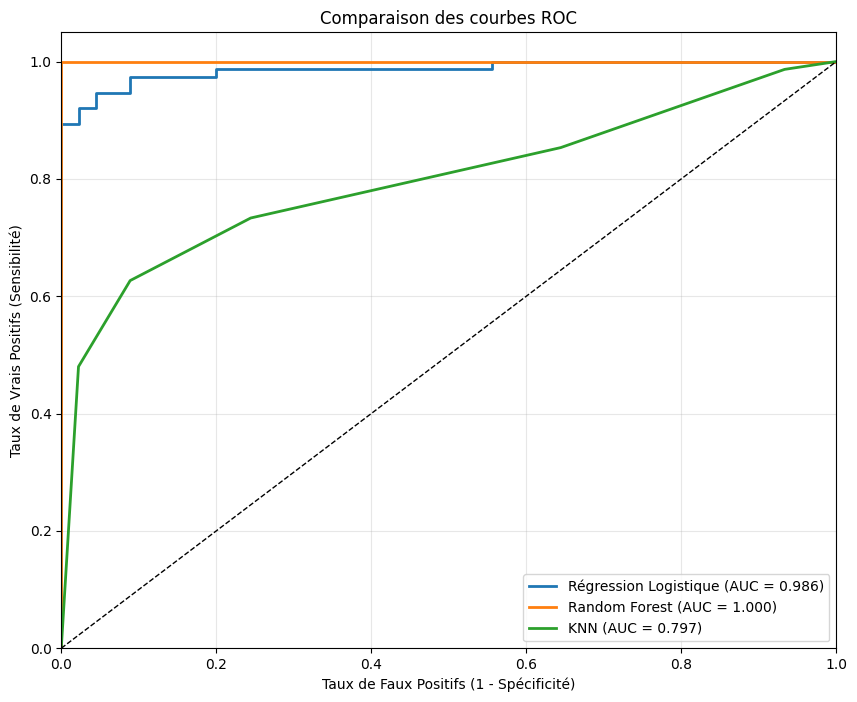

In [34]:
# Graphique comparatif des courbes ROC
plt.figure(figsize=(10, 8))

# Courbe ROC pour la Régression Logistique
plt.plot(fpr_lr, tpr_lr, label=f'Régression Logistique (AUC = {roc_auc_lr:.3f})', linewidth=2)

# Courbe ROC pour Random Forest
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})', linewidth=2)

# Courbe ROC pour KNN
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.3f})', linewidth=2)

# Ligne de référence (classifieur aléatoire)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

# Paramètres du graphique
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (1 - Spécificité)')
plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
plt.title('Comparaison des courbes ROC')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Enregistrer et afficher
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
# Machines à vecteurs de support (SVM)
from sklearn.svm import SVC # Import the SVC class from sklearn.svm
svm_model = SVC(random_state=42, probability=True)  # probability=True pour les courbes ROC
svm_model.fit(X_train, y_train) # Use X_train directly
y_pred_svm = svm_model.predict(X_test) # Use X_test directly
y_prob_svm = svm_model.predict_proba(X_test)[:, 1] # Use X_test directly

# Arbres de décision
from sklearn.tree import DecisionTreeClassifier # Import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train) # Use X_train directly
y_pred_dt = dt_model.predict(X_test) # Use X_test directly
y_prob_dt = dt_model.predict_proba(X_test)[:, 1] # Use X_test directly

# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier # Import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train) # Use X_train directly
y_pred_gb = gb_model.predict(X_test) # Use X_test directly
y_prob_gb = gb_model.predict_proba(X_test)[:, 1] # Use X_test directly

# Évaluation des performances (ex: accuracy, classification_report, roc_auc_score)
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

print("SVM - Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Decision Tree - Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Gradient Boosting - Accuracy:", accuracy_score(y_test, y_pred_gb))

SVM - Accuracy: 0.625
Decision Tree - Accuracy: 0.9916666666666667
Gradient Boosting - Accuracy: 0.9916666666666667


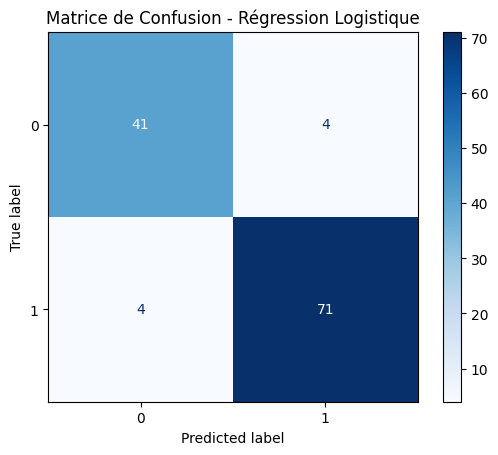

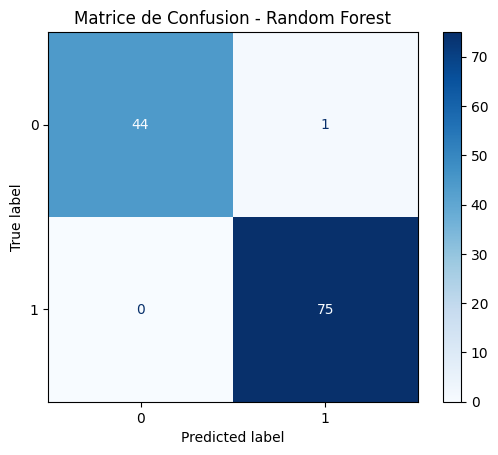

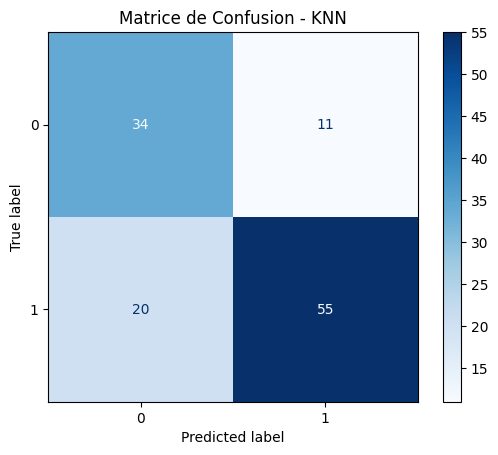

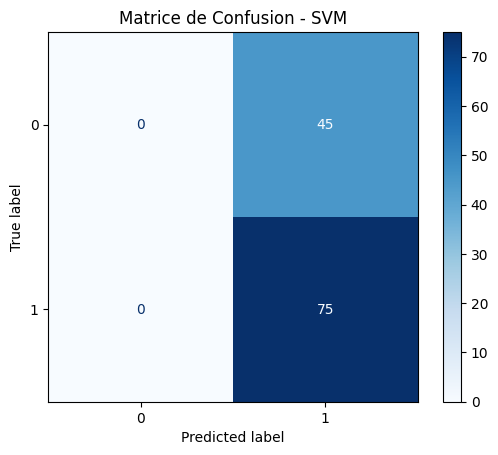

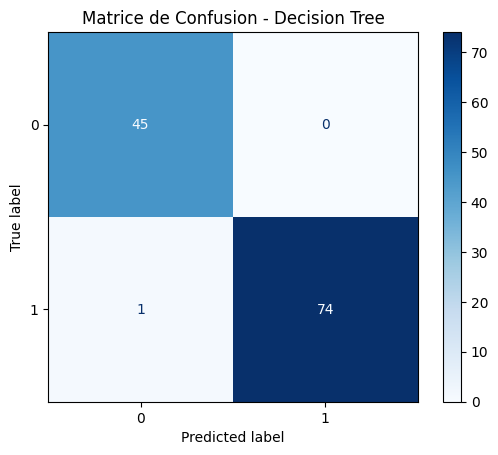

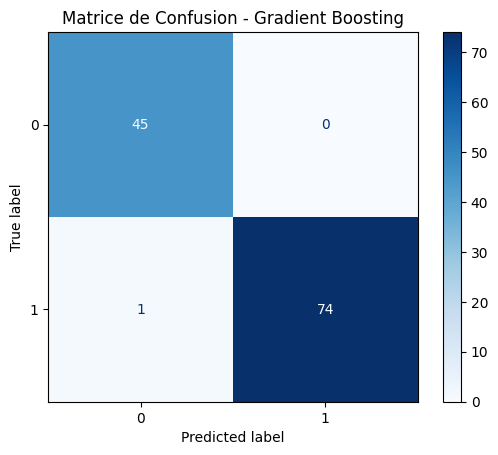

In [36]:
# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matrice de Confusion - {model_name}')
    plt.show()

# Afficher les matrices de confusion pour chaque modèle
plot_confusion_matrix(model_lr, X_test, y_test, 'Régression Logistique')
plot_confusion_matrix(rf_model, X_test_scaled, y_test, 'Random Forest')
plot_confusion_matrix(model_knn, X_test, y_test, 'KNN')
plot_confusion_matrix(svm_model, X_test, y_test, 'SVM')
plot_confusion_matrix(dt_model, X_test, y_test, 'Decision Tree')
plot_confusion_matrix(gb_model, X_test, y_test, 'Gradient Boosting')